In [2]:
import os, time, copy
from collections import OrderedDict
from glob import glob

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as vmodels
import torchvision.datasets as vdatasets

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
import matplotlib.font_manager as fm
path = '/Library/Fonts/NanumBarunGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

from PIL import Image as pil_image

import numpy as np
from skimage.transform import resize
from skimage.measure import label, regionprops

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Resnet_fc(nn.Module):
    def __init__(self, base_model, nb_classes):
        super(Resnet_fc, self).__init__()

        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])

        tmp = OrderedDict()
        tmp['last_conv'] = nn.Conv2d(2048, nb_classes, 1, 1)
        tmp['gap'] = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

        self.classifier_layer = nn.Sequential(tmp)

    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        x = self.classifier_layer(features)
        return F.sigmoid(x), features

In [4]:
base_model = vmodels.resnet50(pretrained=False)
net = Resnet_fc(base_model, 5)
net.load_state_dict(torch.load("../weights/pred_fullyconv/mse/best_model_e25_val_acc0.96.pth.tar", map_location='cpu'))
# net.load_state_dict(torch.load("../weights/pred_fullyconv/best_model_e16_val_acc0.95.pth.tar", map_location='cpu'))
net.eval()
net.to(device)

test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
img_array.shape

NameError: name 'img_array' is not defined

In [6]:
img_path = 'samples/all.jpg'

img = pil_image.open(img_path)
img_array = np.asarray(img)[:, :, :3]
n_H, n_W, n_C = img_array.shape

scaleFactor = (int(1024*n_H / n_W), 1024)
img_array = resize(img_array, scaleFactor)
n_H, n_W, n_C = img_array.shape

to_feed = copy.deepcopy(img_array)
inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
inp_tensor = inp_tensor.to(device)

output, features = net(inp_tensor)

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0
33
max: 0.964
min: 0.232
mean: 0.705


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


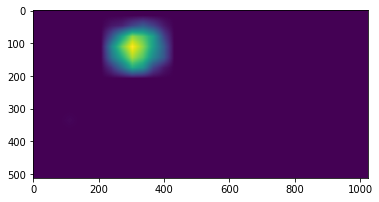

1
45
max: 0.974
min: 0.286
mean: 0.774


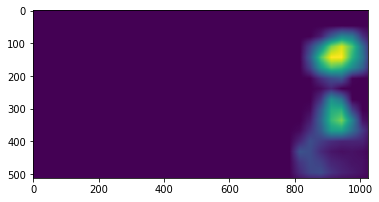

2
22
max: 0.985
min: 0.225
mean: 0.718


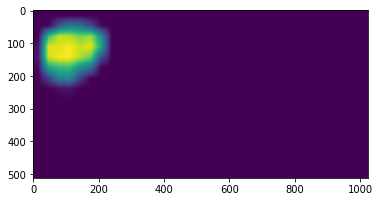

3
118
max: 0.974
min: 0.226
mean: 0.585


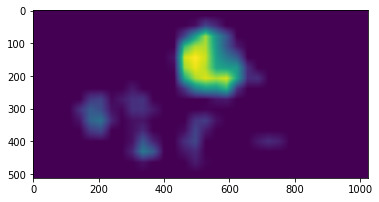

4
42
max: 0.907
min: 0.243
mean: 0.512


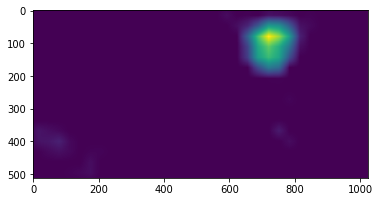

In [7]:
for cls in [0, 1, 2, 3, 4]:
    print(cls)


    s_1, s_2 = features.size()[2:]

    sl_1 = s_1-7+1
    sl_2 = s_2-7+1

    W_conv = net.classifier_layer.last_conv.weight.detach()
    W_conv_c = W_conv[cls]

    probs = []

    A_conv_c = torch.zeros(1, s_1, s_2)
    for i in range(sl_1):
        for j in range(sl_2):

            target_softmax = output[0][cls,i,j]
            
            max_cls = torch.argmax(output[0][:,i,j]).item()
            if cls == max_cls:

                if target_softmax > 0.2:
                    probs.append(target_softmax.item())

                    a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
                    A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
                    
    _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
    _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
    A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
    canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), scaleFactor)
    print(len(probs))
    if len(probs) > 0:
        print("max: {:.3f}".format(max(probs)))
        print("min: {:.3f}".format(min(probs)))
        print("mean: {:.3f}".format(np.mean(probs)))

    plt.imshow(canvas)
    plt.show()

In [8]:
test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
cls2name = {0: '안철수', 1: '홍준표', 2:'문재인', 3:'심상정', 4:'유승민'}
cls2color = {0: 'green', 1: 'red', 2:'blue', 3:'yellow', 4:'teal'}

In [10]:
# def run_inference(img_path, is_heatmap, save=False, save_dir=None):
#     img = pil_image.open(img_path)
    
#     img = pil_image.open(img_path)
#     img_array = np.asarray(img)[:, :, :3]
#     n_H, n_W, n_C = img_array.shape

#     if n_W > n_H:
#         scaleFactor = (int(1024*n_H / n_W), 1024)
#     else:
#         scaleFactor = (1024, int(1024*n_W / n_H))
#     img_array = resize(img_array, scaleFactor)
#     n_H, n_W, n_C = img_array.shape
#     print(n_H, n_W, n_C)

#     to_feed = copy.deepcopy(img_array)
#     inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
#     inp_tensor = inp_tensor.to(device)

#     output, features = net(inp_tensor)
    
#     fig, ax = plt.subplots(figsize=(12, 10))
#     ax.imshow(img_array)
#     ax.axis("off")
    
#     for cls in [0, 1, 2, 3, 4]:
        
#         s_1, s_2 = features.size()[2:]

#         sl_1 = s_1-7+1
#         sl_2 = s_2-7+1

#         W_conv = net.classifier_layer.last_conv.weight.detach()
#         W_conv_c = W_conv[cls]

#         probs = []

#         A_conv_c = torch.zeros(1, s_1, s_2)
#         for i in range(sl_1):
#             for j in range(sl_2):

#                 target_softmax = output[0][cls,i,j]

#                 max_cls = torch.argmax(output[0][:,i,j]).item()
#                 if cls == max_cls:

#                     if target_softmax > 0.5:
#                         probs.append(target_softmax.item())

#                         a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
#                         A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)

#         _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
#         _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
#         A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
        
# #         print(len(probs))
# #         if len(probs) > 0:
# #             print("max: {:.3f}".format(max(probs)))
# #             print("min: {:.3f}".format(min(probs)))
# #             print("mean: {:.3f}".format(np.mean(probs)))

# #         plt.imshow(canvas)
# #         plt.show()
    
#         if len(probs) > 0:
#             if np.max(probs) > 0.9:
#                 canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), scaleFactor)
#             else:
#                 canvas = np.zeros(img_array.shape[:2])
#         else:
#             canvas = np.zeros(img_array.shape[:2])

    
#         if is_heatmap:
#             ax.imshow(canvas, cmap='jet', alpha=0.5)
#         else:
#             labeled = label(canvas > 0.3)
#             props = regionprops(labeled)

#             rects = []
#             for p in props:
#                 ys, xs, ye, xe = p.bbox
#                 w = xe - xs
#                 h = ye - ys

#                 if w * h > 3000:
#                     print(w, h)

#                     rect = patches.Rectangle((xs, ys), w, h, linewidth=3, edgecolor=cls2color[cls], facecolor='none', alpha=0.75)
#                     rects.append(rect)
#                     ax.text(x=xs + 5, y=ys + 23, s=cls2name[cls], fontproperties=fontprop, color=cls2color[cls])

#             for r in rects:
#                 ax.add_patch(r)
                    
    
#     if save:
#         fname = os.path.basename(img_path)
#         full_path = os.path.join(save_dir, fname)
#         fig.savefig(full_path, bbox_inches='tight')
#         print("saved - {}".format(full_path))
#     else:
#         plt.show()

In [210]:
def run_inference(img_path, is_heatmap, save=False, save_dir=None):
    img = pil_image.open(img_path)
    
    img = pil_image.open(img_path)
    img_array = np.asarray(img)[:, :, :3]
    n_H, n_W, n_C = img_array.shape

    if n_W > n_H:
        scaleFactor = (int(1024*n_H / n_W), 1024)
    else:
        scaleFactor = (1024, int(1024*n_W / n_H))
    
    img_array = resize(img_array, scaleFactor)
    n_H, n_W, n_C = img_array.shape
    
    to_feed = copy.deepcopy(img_array)
    inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)

    output, features = net(inp_tensor)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img_array)
        
    
    cls_coords = {}
    
    for cls in [0]:
    
        s_1, s_2 = features.size()[2:]

        sl_1 = s_1-7+1
        sl_2 = s_2-7+1

        W_conv = net.classifier_layer.last_conv.weight.detach()
        W_conv_c = W_conv[cls]
        
        rects = {}
        
        counter = 0
        
#         A_conv_c = torch.zeros(1, s_1, s_2)
        A_conv_c = torch.full((1, s_1, s_2), np.inf)
        
        for i in range(sl_1):
            for j in range(sl_2):
                counter += 1
                
                region_output = output[:, cls, i, j].item()
                if region_output > 0.9:

                    
                    a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
#                     A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
                    A_conv_c[:, i:i+7, j:j+7] = torch.min(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
        

        A_conv_c[A_conv_c == float("Inf")] = 0
        _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
        _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
        A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
        
#         A_conv_c_normalized = A_conv_c


        canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), scaleFactor)
#                     canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), (n_H, n_W))

        if is_heatmap:
            ax.imshow(canvas, cmap='jet', alpha=0.5)
        else:
            labeled = label(canvas > 0.3)
            props = regionprops(labeled)

            rects = []
            for p in props:
                ys, xs, ye, xe = p.bbox
                w = xe - xs
                h = ye - ys

                if w * h > 3000:

                    rect = patches.Rectangle((xs, ys), w, h, linewidth=3, edgecolor=cls2color[cls], facecolor='none', alpha=0.75)
                    rects.append(rect)
                    ax.text(x=xs + 5, y=ys + 23, s=cls2name[cls], fontproperties=fontprop, color=cls2color[cls])

            for r in rects:
                ax.add_patch(r)
#                  
    plt.show()

In [211]:
x = torch.full((3, 1), -np.inf)
x[x == -float("Inf")] = 0
x

tensor([[ 0.],
        [ 0.],
        [ 0.]])

In [212]:
# def run_inference(img_path, is_heatmap, save=False, save_dir=None):
#     img = pil_image.open(img_path)
    
#     img = pil_image.open(img_path)
#     img_array = np.asarray(img)[:, :, :3]
#     n_H, n_W, n_C = img_array.shape

#     if n_W > n_H:
#         scaleFactor = (int(1024*n_H / n_W), 1024)
#     else:
#         scaleFactor = (1024, int(1024*n_W / n_H))
    
#     img_array = resize(img_array, scaleFactor)
#     n_H, n_W, n_C = img_array.shape
    
#     to_feed = copy.deepcopy(img_array)
#     inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
#     inp_tensor = inp_tensor.to(device)

#     output, features = net(inp_tensor)
    
#     cls_coords = {}
    
#     for cls in [0, 1, 2, 3, 4]:
    
#         s_1, s_2 = features.size()[2:]

#         sl_1 = s_1-7+1
#         sl_2 = s_2-7+1

#         W_conv = net.classifier_layer.last_conv.weight.detach()
#         W_conv_c = W_conv[cls]
        
#         rects = {}
        
#         counter = 0
#         for i in range(sl_1):
#             for j in range(sl_2):
#                 counter += 1
                
#                 region_output = output[:, cls, i, j].item()
                
#                 if region_output > 0.99:


#                     A_conv_c = torch.zeros(1, s_1, s_2)

#                     a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
#                     A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)

#                     _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
#                     _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
#                     A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)


#                     canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), scaleFactor)
# #                     canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), (n_H, n_W))

#                     labeled = label(canvas > 0.3)
#                     props = regionprops(labeled)

#                     for p in props:
#                         ys, xs, ye, xe = p.bbox
#                         w = xe - xs
#                         h = ye - ys
#                         tmp = {
#                             'prob': region_output,
#                             'xs': xs,
#                             'ys': ys,
#                             'w': w,
#                             'h': h
#                         }
#                         rects[counter] = tmp
                        
#         cls_coords[cls] = rects
        
#         print("cls: {} done".format(cls))
        
# #     return cls_coords
        
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.imshow(img_array)
        
#     for cls in [0, 1, 2, 3, 4]:
#         nmm_rects = non_max_merge(cls_coords[cls], 0.01)
             
#         current_rects = nmm_rects
#         for cd in current_rects:
# #         for k, cd in cls_coords[cls].items():
#             rect = patches.Rectangle((cd['xs'], cd['ys']), cd['w'], cd['h'], linewidth=3, edgecolor=cls2color[cls], facecolor='none', alpha=0.75)
#             ax.add_patch(rect)
#     plt.show()

In [213]:
def centre_to_coord(xs, ys, w, h):
    xe = xs + w
    ye = ys + h
    return xs, xe, ys, ye
    

def calculate_iou(box_1, box_2):
    
    xs1, xe1, ys1, ye1 = centre_to_coord(box_1['xs'], box_1['ys'], box_1['w'], box_1['h'])
    xs2, xe2, ys2, ye2 = centre_to_coord(box_2['xs'], box_2['ys'], box_2['w'], box_2['h'])
    
    #intersection
    xs_i = max(xs1, xs2)
    ys_i = max(ys1, ys2)
    xe_i = min(xe1, xe2)
    ye_i = min(ye1, ye2)
    
    #intersection: width, height
    w_i = max(xe_i - xs_i, 0)
    h_i = max(ye_i - ys_i, 0)
    box_int = w_i * h_i
    
    #union
    box_1_area = box_1['w'] * box_1['h']
    box_2_area = box_2['w'] * box_2['h']
    box_uni = box_1_area + box_2_area - box_int
    
    #iou
    iou = box_int / box_uni
    return iou

In [214]:
def non_max_merge(cls_coord, min_merge_thres=0.6):

    # merge lower pred boxes that are over min thres
    
    current = cls_coord.copy()

    to_merge_list = []
    while len(current) > 0:

        # 1. pick max
        to_merge = []
        max_item = max(current.items(), key=lambda x: x[1]['prob'])
        to_merge.append(max_item[1])

        to_remove = []
        for k, v in current.items():
            iou = calculate_iou(max_item[1], v)
            if iou > min_merge_thres:
                to_merge.append(v)
                to_remove.append(k)

        to_merge_list.append(to_merge)
        for idx in to_remove:
            current.pop(idx)
            
    
    # merge coordinates
    non_max_merge = []
    
    for to_merge in to_merge_list:
        xs_list = []
        ys_list = []
        xe_list = []
        ye_list = []

        for box in to_merge:
            xs, xe, ys, ye = centre_to_coord(box['xs'], box['ys'], box['w'], box['h'])
            xs_list.append(xs)
            ys_list.append(ys)
            xe_list.append(xe)
            ye_list.append(ye)

        m_xs = min(xs_list)
        m_ys = min(ys_list)
        m_xe = max(xe_list)
        m_ye = max(ye_list)

        tmp = {
            'xs': m_xs,
            'ys': m_ys,
            'w': m_xe - m_xs,
            'h': m_ye - m_ys,
        }
        non_max_merge.append(tmp)
    
    return non_max_merge

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


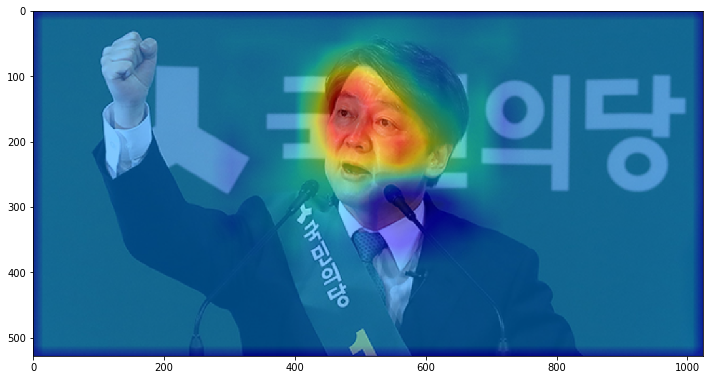

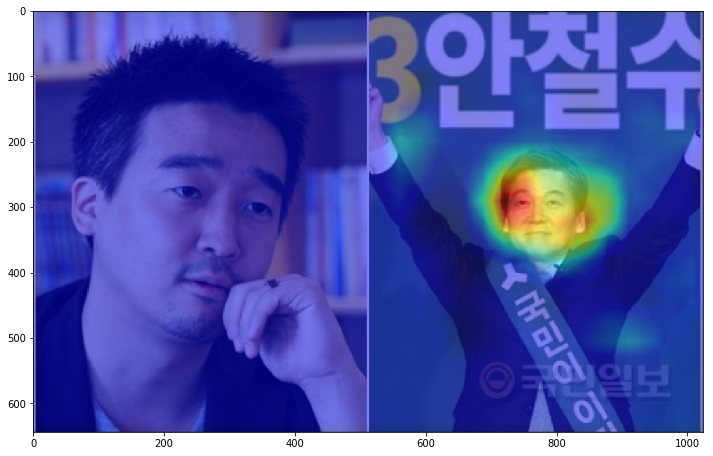

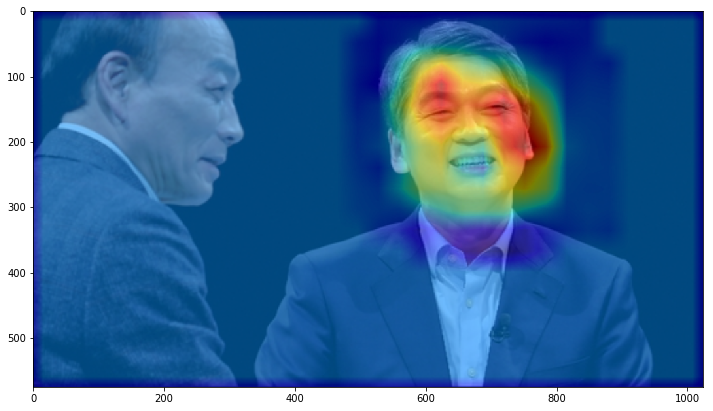

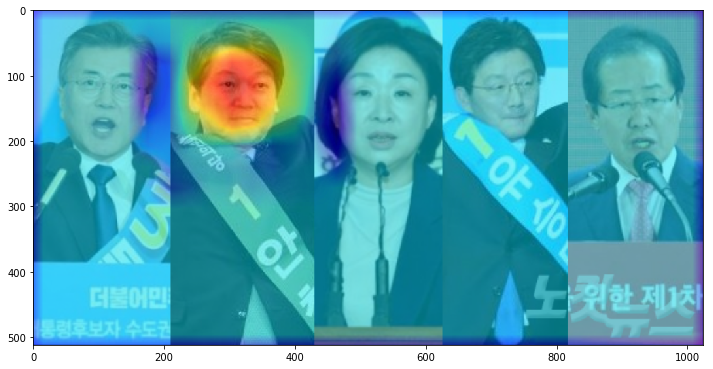

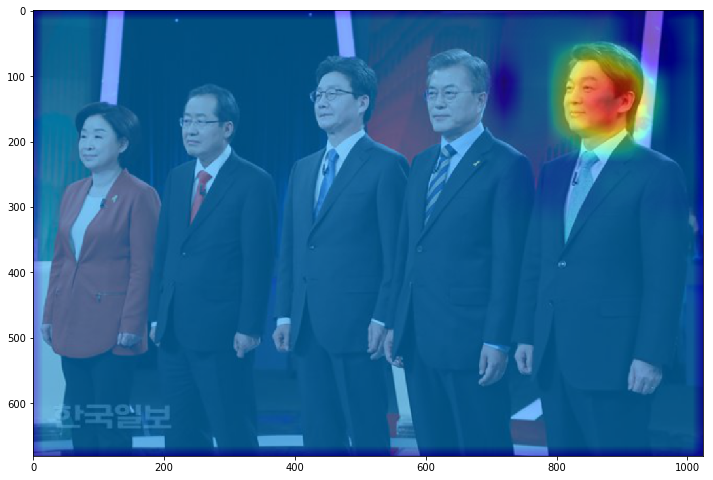

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


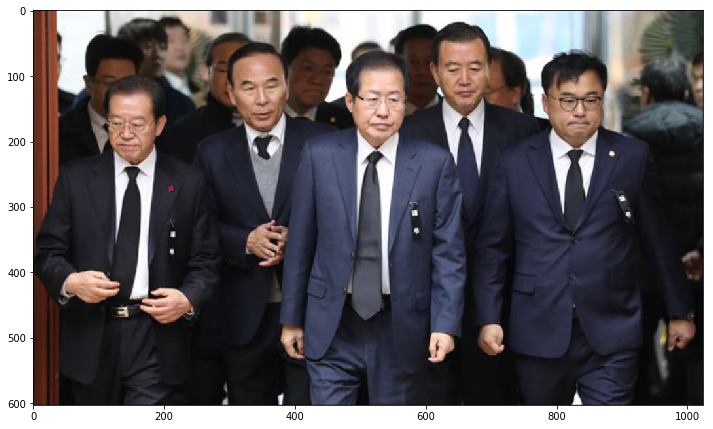

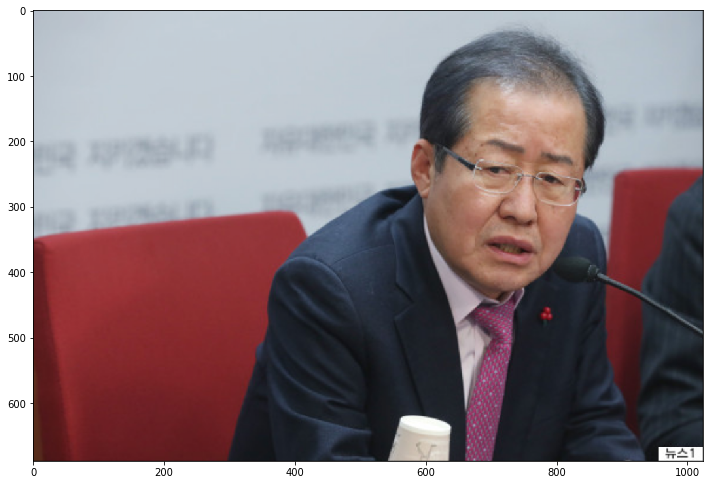

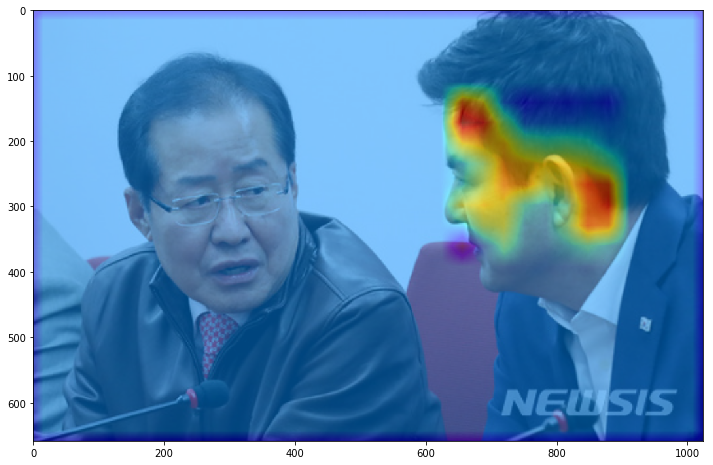

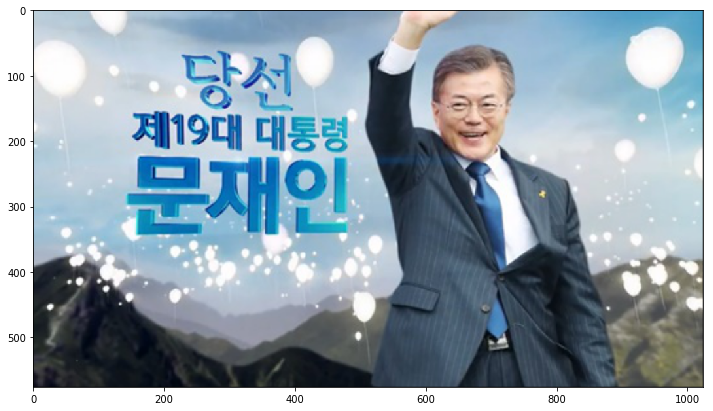

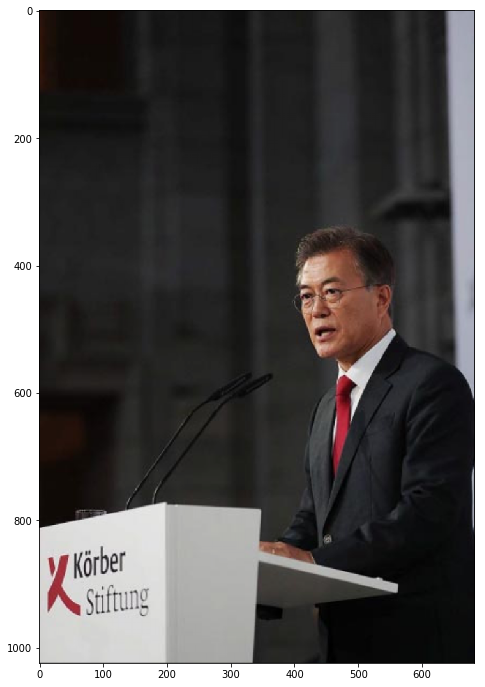

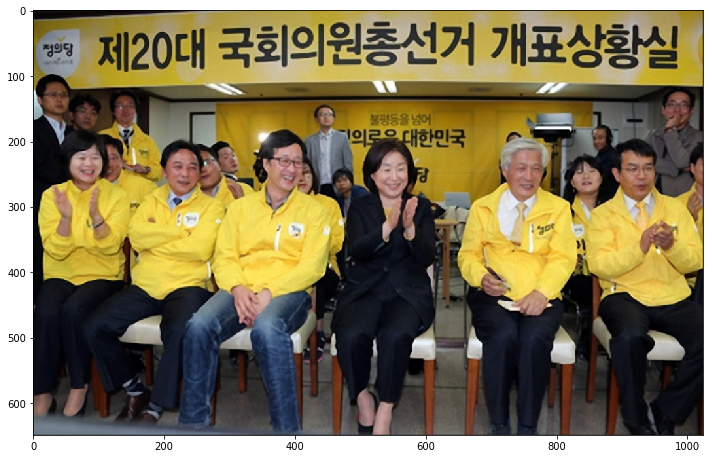

KeyboardInterrupt: 

In [215]:
for p in glob("samples/*.jpg"):
    run_inference(p, is_heatmap=True, save=False, save_dir='video_res')

In [167]:
non_max_merge = []

for to_merge in to_merge_list:
    xs_list = []
    ys_list = []
    xe_list = []
    ye_list = []

    for box in to_merge:
        xs, xe, ys, ye = centre_to_coord(box['xs'], box['ys'], box['w'], box['h'])
        xs_list.append(xs)
        ys_list.append(ys)
        xe_list.append(xe)
        ye_list.append(ye)

    m_xs = min(xs_list)
    m_ys = min(ys_list)
    m_xe = max(xe_list)
    m_ye = max(ye_list)

    tmp = {
        'xs': m_xs,
        'ys': m_ys,
        'xe': m_xe,
        'ye': m_ye
    }
    non_max_merge.append(tmp)

NameError: name 'to_merge_list' is not defined

In [ ]:
xs_list = []
ys_list = []
xe_list = []
ye_list = []

for box in to_merge_list[0]:
    xs, xe, ys, ye = centre_to_coord(box['xs'], box['ys'], box['w'], box['h'])
    xs_list.append(xs)
    ys_list.append(ys)
    xe_list.append(xe)
    ye_list.append(ye)
    
m_xs = min(xs_list)
m_ys = min(ys_list)
m_xe = max(xe_list)
m_ye = max(ye_list)

print(m_xs, m_ys, m_xe, m_ye)

In [ ]:
to_merge_list

In [ ]:
calculate_iou(current[6], current[8])

In [ ]:
for k, v in current.items():
    print(k, v['prob'])

In [ ]:
# 1. find box with maximum value
current = cls_coords[0]
visited = set()
print(current)
max(current, key=lambda x: x['prob'])
# max_idx = max(current, key=lambda x: x['prob'])['idx']
# visited.add(max_idx)
# unvisited = [c['idx'] for c in current if c['idx'] not in visited]

# for u_idx in unvisited:
#     print(current[])



In [ ]:
max(current, key=lambda x: x['prob'])

In [ ]:
[c['idx'] for c in current if c['idx'] not in visited]
    

In [ ]:
visited

In [ ]:
#cls_coords

fig, ax = plt

In [ ]:
from glob import glob

In [ ]:
paths = glob("samples/*.jpg")

In [ ]:
for p in paths:
    run_inference(p, is_heatmap=False, save=False, save_dir=None)

In [ ]:
import glob

In [ ]:
paths = sorted(glob.glob("../datasets/presidential_debate_frames_v2/*.jpg"))

In [ ]:
for p in paths:
    run_inference(p, is_heatmap=False, save=True, save_dir='video_mse')